In [243]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from pandas.plotting import scatter_matrix
import hashlib
from sklearn.preprocessing import LabelEncoder, OneHotEncoder,StandardScaler, LabelBinarizer
from sklearn.impute import SimpleImputer as Imputer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import mean_squared_error

def load_data():
    return pd.read_csv('../data/housing.csv')

In [201]:
#main
housing = load_data()
#create a sample Set: params -> (DataFrame, ratio, seed)
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

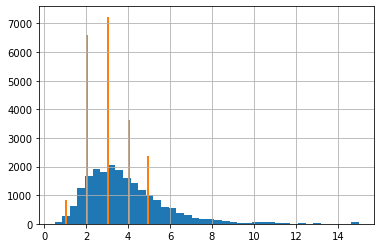

In [202]:
"""
Create an income category by dividing the median income by 1.5 (to limit the income ccategories)
and rounding up using ceil.

then merging all categories > 5 to 5
"""
housing["median_income"].hist(bins=40)
housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)
#pandas where method: if (true cool) else use the 2nd argument and change the value in place
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True) 
housing["income_cat"].hist(bins=40) #orange hist : combined categories


In [203]:
"""STRATIFIED SAMPLING : TO avoid bias"""

#provides train, test indices to split data for testing and training
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

print(len(housing["income_cat"]))

#split( dataset (n_samples x n_features), labels(n_samples)) 
#split returns  ndarray , ndarray - > (training set indices, test set indices)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

20640


In [204]:
len(housing)
#now we dealing with just the stratifeid set
housing = strat_train_set.copy()

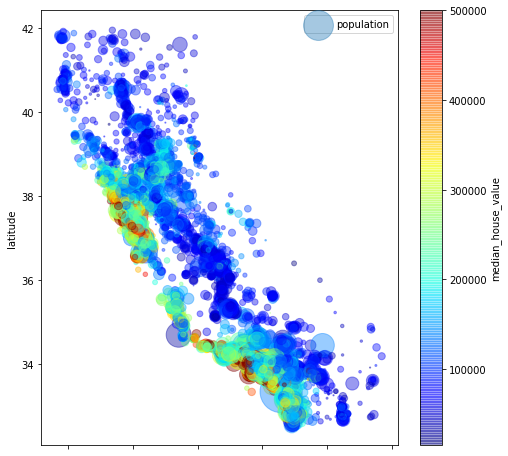

In [205]:
housing.plot(kind="scatter", x="longitude", y="latitude", 
             alpha=0.4, s=housing["population"]/20, label="population",
            c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True, figsize=(8, 8)
            )
plt.legend()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x128996c50>,
      dtype=object)

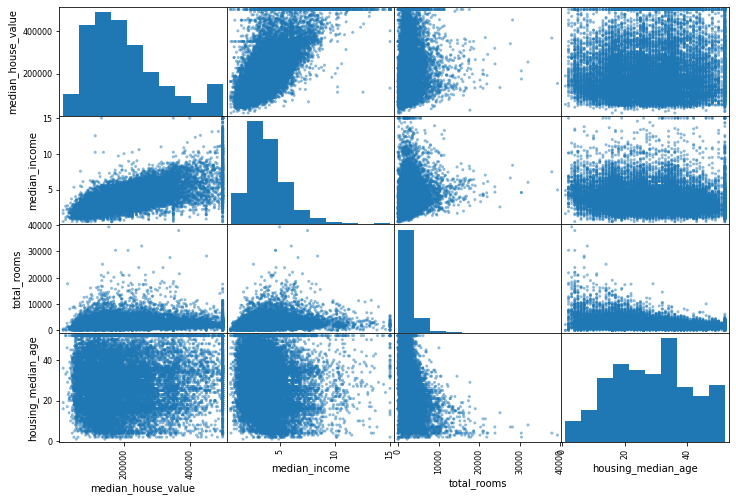

In [206]:
"""Looking for correlations"""
atrs = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[atrs], figsize=(12, 8))

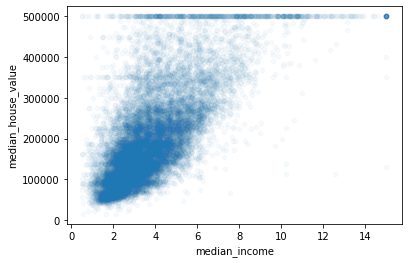

In [207]:
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.03)

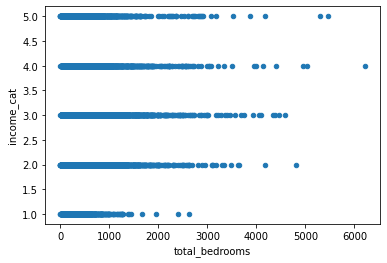

In [208]:
"""DATA CLEANING"""
housing.plot(kind="scatter", x="total_bedrooms", y="income_cat")


In [209]:
# deal with missing features
#fill the missing values with the median
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

In [210]:
#deal with missing bedrooms
housing["total_bedrooms"].fillna(housing["total_bedrooms"].median())

17606     351.0
18632     108.0
14650     471.0
3230      371.0
3555     1525.0
          ...  
6563      236.0
12053     294.0
13908     872.0
11159     380.0
15775     682.0
Name: total_bedrooms, Length: 16512, dtype: float64

In [211]:
"""LabelEncoder : Dealing with textual features and converting them into numbers"""
encoder = LabelEncoder()
hc = housing["ocean_proximity"]
hc_en = encoder.fit_transform(hc)
print(hc_en)

[0 0 4 ... 1 0 3]


In [212]:
print(encoder.classes_)

['<1H OCEAN' 'INLAND' 'ISLAND' 'NEAR BAY' 'NEAR OCEAN']


In [213]:
#convert these values into one-hot binary vectors
ecdr = OneHotEncoder()
hc_1hot = ecdr.fit_transform(hc_en.reshape(-1, 1))
print(hc_1hot.toarray())



[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 ...
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]]


In [214]:
tr = housing["total_rooms"]

In [176]:
"""Transformational Pipelines"""

imputer = Imputer(strategy="median")
housing_num = housing.drop("ocean_proximity", axis=1)

num_pipeline = Pipeline([
    ('imputer',  Imputer(strategy="median")),
    ('std_scaler', StandardScaler())
])

In [234]:


def dfsel(data, x):
    return data[x]
            
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values




In [235]:
#transform and feature union
nums = list(housing_num) #num types
cats = ["ocean_proximity"] #category types


housing[nums]

num_pipeline = Pipeline([
    ('selector', DataFrameSelector(nums)),
    ('imputer', Imputer(strategy='median')),
    ('std_scaler', StandardScaler()),
])

cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(cats)),
    ('label_binarizer', LabelBinarizer())
])

full_pipeline = Pipeline([
    ('num_pipeline', num_pipeline),
    ('cat_pipeline', cat_pipeline)
])

housing_prepared = num_pipeline.fit_transform(housing)

In [238]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [245]:
hps = tree_reg.predict(housing_prepared)
mse = mean_squared_error(housing_labels, hps)
rmse = np.sqrt(mse)

In [246]:
print(rmse)

0.0
